In [1]:
import time
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from statistics import mean

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from itertools import combinations

import random
from tqdm import tqdm # Progress Bar

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
from statistics import mean

import cv2

import itertools
import random
import os

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device


device(type='cpu')

In [3]:
def random_images(dataset_folder):
    random_images = []
    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        filenames = os.listdir(person_folder_path)
        if len(filenames) > 10:
            filenames = random.sample(filenames, 10)
        for filename in filenames:
            random_images.append(os.path.join(person_folder_path, filename))
    return random_images

In [4]:
import os
import random
import pandas as pd
import itertools

def triplet_dataset_preparation(dataset_folder):
    image_paths = random_images(dataset_folder)
    # Create an empty list to hold data
    data = []

    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        genuine_images = []
        forged_images = []

        for filename in os.listdir(person_folder_path):
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(os.path.join(person_folder_path, filename))
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(os.path.join(person_folder_path, filename))

        additional_images = random.sample(image_paths, 15)
        forged_images.extend(additional_images)

        num_combinations = min(len(genuine_images) * (len(genuine_images) - 1) // 2, len(genuine_images) * len(forged_images))
        genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
        forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

        # Prepare the balanced triplets
        for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
            anchor_path = os.path.join(image_1)
            positive_path = os.path.join(image_2)
            negative_path = os.path.join(forged_image)
            data.append([anchor_path, positive_path, negative_path])

    # Convert the list into a DataFrame
    df = pd.DataFrame(data, columns=['Anchor_Path', 'Positive_Path', 'Negative_Path'])
    return df


def duplet_dataset_preparation(dataset_folder):
    image_paths = random_images(dataset_folder)
    # Create an empty list to hold data
    data = []

    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)

        genuine_images = []
        forged_images = []
        for filename in os.listdir(person_folder_path):
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(os.path.join(person_folder_path, filename))
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(os.path.join(person_folder_path, filename))

        additional_images = random.sample(image_paths, 10)
        forged_images.extend(additional_images)

        num_genuine_images = len(genuine_images)
        num_forged_images = len(forged_images)
        num_combinations = min(num_genuine_images * (num_genuine_images - 1) // 2, num_genuine_images * num_forged_images)
        genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
        forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

        # Prepare the balanced combinations
        for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
            anchor_path = os.path.join(image_1)
            positive_path = os.path.join(image_2)
            label = 1
            data.append([anchor_path, positive_path, label])

            anchor_path = os.path.join(genuine_image)
            positive_path = os.path.join(forged_image)
            label = 0
            data.append([anchor_path, positive_path, label])

    # Convert the list into a DataFrame
    df = pd.DataFrame(data, columns=['Image1', 'Image2', 'Label'])
    return df


In [6]:
cedar_dataset = './signature-dataset/Train'
cedar_df = triplet_dataset_preparation(cedar_dataset)

cedar_df = cedar_df.sample(30000, random_state=42)
print(cedar_df.shape)

(30000, 3)


In [7]:
cedar_df.sample(10)

,Anchor_Path,Positive_Path,Negative_Path
31618,./signature-dataset/Train/14/original_14_8.png,./signature-dataset/Train/14/original_14_20.png,./signature-dataset/Train/14/forgeries_14_5.png
22675,./signature-dataset/Train/55/original_55_4.png,./signature-dataset/Train/55/original_55_12.png,./signature-dataset/Train/46/original_46_10.png
14865,./signature-dataset/Train/72/B-S-72-G-10.jpg,./signature-dataset/Train/72/B-S-72-G-13.jpg,./signature-dataset/Train/99/B-S-99-F-01.jpg
31223,./signature-dataset/Train/13/original_13_20.png,./signature-dataset/Train/13/original_13_10.png,./signature-dataset/Train/77/B-S-77-F-29.jpg
2463,./signature-dataset/Train/68/B-S-68-G-06.jpg,./signature-dataset/Train/68/B-S-68-G-22.jpg,./signature-dataset/Train/68/B-S-68-F-24.jpg
720,./signature-dataset/Train/95/B-S-95-G-13.jpg,./signature-dataset/Train/95/B-S-95-G-06.jpg,./signature-dataset/Train/130/H-S-130-G-16.jpg
28317,./signature-dataset/Train/12/original_12_13.png,./signature-dataset/Train/12/original_12_4.png,./signature-dataset/Train/135/H-S-135-F-27.jpg
30422,./signature-dataset/Train/47/original_47_14.png,./signature-dataset/Train/47/original_47_18.png,./signature-dataset/Train/47/forgeries_47_7.png
17267,./signature-dataset/Train/131/H-S-131-G-03.jpg,./signature-dataset/Train/131/H-S-131-G-24.jpg,./signature-dataset/Train/131/H-S-131-F-27.jpg
18705,./signature-dataset/Train/96/B-S-96-G-14.jpg,./signature-dataset/Train/96/B-S-96-G-24.jpg,./signature-dataset/Train/84/B-S-84-F-18.jpg


In [8]:
class TripletDataset(Dataset):
    
    def __init__(self, training_df=None,transform=None):
        self.training_df = training_df
        self.training_df.columns = ["Anchor_Path", "Positive_Path", "Negative_Path"]  
        self.transform = transform

    def __getitem__(self, index):
        # Getting the image paths
        anchor_path = os.path.join(self.training_df.iat[int(index), 0])
        positive_path = os.path.join(self.training_df.iat[int(index), 1])
        negative_path = os.path.join(self.training_df.iat[int(index), 2])

        # Loading the images
        anchor_img = Image.open(anchor_path)
        positive_img = Image.open(positive_path)
        negative_img = Image.open(negative_path)
        
        # preprocess the image
        anchor_img = preprocess_image(anchor_img)
        positive_img = preprocess_image(positive_img)
        negative_img = preprocess_image(negative_img)
        
        # Apply image transformations
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.training_df)


class DupletDataset(Dataset):
    
    def __init__(self,dataframe=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=dataframe
        self.training_df.columns =["image1","image2","label"]   
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_df.iat[int(index),0])
        image2_path=os.path.join(self.training_df.iat[int(index),1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = preprocess_image(img0)
        img1 = preprocess_image(img1)
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        label = torch.from_numpy(np.array([int(self.training_df.iat[int(index), 2])], dtype=np.float32))
        
        return img0, img1 , label
    
    def __len__(self):
        return len(self.training_df)

In [9]:
def preprocess_image(image_pth):
    
    # Convert image to grayscale
    gray = image_pth.convert("L")

    # Convert grayscale image to numpy array
    img = np.array(gray)
    # Apply median blur
    blur = cv2.medianBlur(img,3)

    # Define kernel for morphology operations
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    # Perform erosion
    erode = cv2.erode(blur, kernel, iterations=2)

    # Perform dilation
    dilate = cv2.dilate(erode, kernel, iterations=1)

    # Apply thresholding
    _, binary = cv2.threshold(dilate, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find the bounding box coordinates of the non-white pixels
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    padding = 20  # Adjust the padding size as needed
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    # Make sure the coordinates are within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the image using the modified bounding box coordinates
    cropped_image = binary[y:y+h, x:x+w]

    # Add extra white space around the cropped image
    extra_space = np.zeros((cropped_image.shape[0] + 2 * padding, cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image
    
    # Convert the numpy array back to PIL image
    resized_image = Image.fromarray(extra_space)

    return resized_image

In [10]:
def plot_images(img):
    fig, axes = plt.subplots(1,2, figsize=(10,10))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("before_preprocessing")

    after_preprocessing = preprocess_image(img)
    print(after_preprocessing.size)
    axes[1].imshow(after_preprocessing)
    axes[1].axis('off')
    axes[1].set_title("after_preprocessing")

(322, 199)


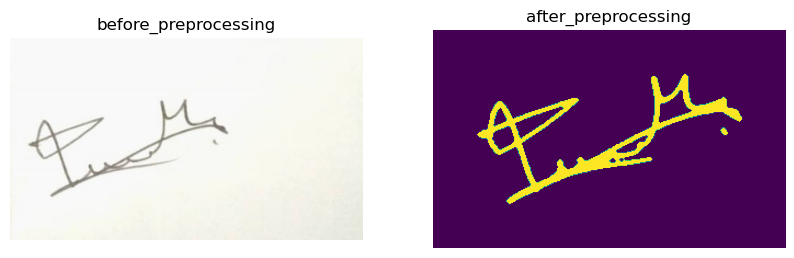

In [11]:
img = Image.open('./signature-dataset/Train/5/forge_05_02.jpg')
plot_images(img)


(310, 161)


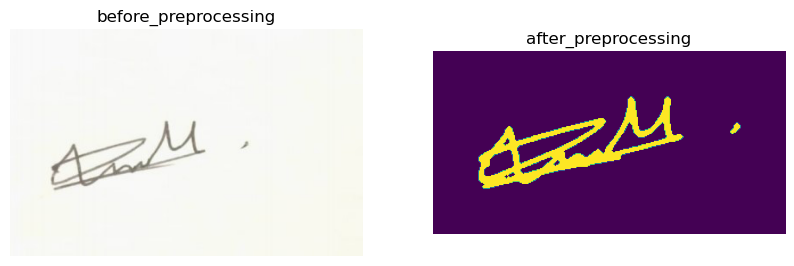

In [12]:
img = Image.open('./signature-dataset/Train/5/original_05_02.jpg')
plot_images(img)

In [13]:
transformation = transforms.Compose([
    transforms.Resize((200,300)),
    transforms.RandomRotation((-5,10)),
    transforms.ToTensor(),
])

In [14]:
def show_triplets_from_dataloader(dataloader, num_triplets=3):
    for batch_idx, (anchor_imgs, positive_imgs, negative_imgs) in enumerate(dataloader):
        for i in range(len(anchor_imgs)):
            if i >= num_triplets:
                break

            # Display the anchor, positive, and negative images
            fig, axes = plt.subplots(1, 3, figsize=(8, 4))
            axes[0].imshow(anchor_imgs[i].permute(1, 2, 0))  # Permute dimensions for image display (assuming tensor input)
            axes[0].set_title("Anchor")
            axes[1].imshow(positive_imgs[i].permute(1, 2, 0))
            axes[1].set_title("Positive")
            axes[2].imshow(negative_imgs[i].permute(1, 2, 0))
            axes[2].set_title("Negative")
            plt.tight_layout()
            plt.show()

In [15]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

dataset =  TripletDataset(cedar_df, transform = transformation)

batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size)

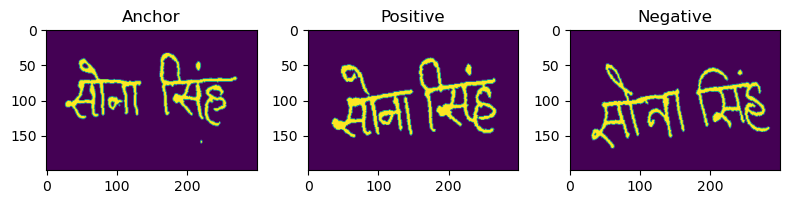

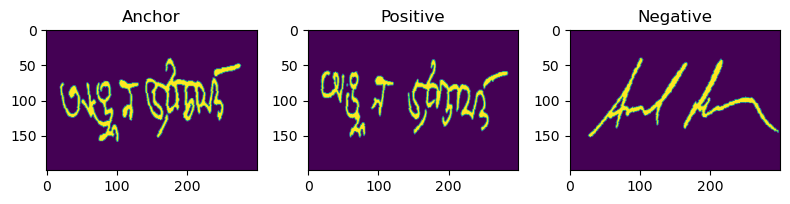

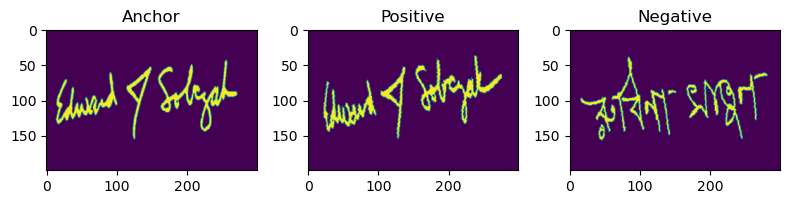

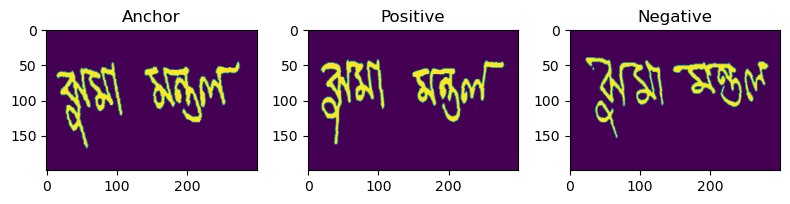

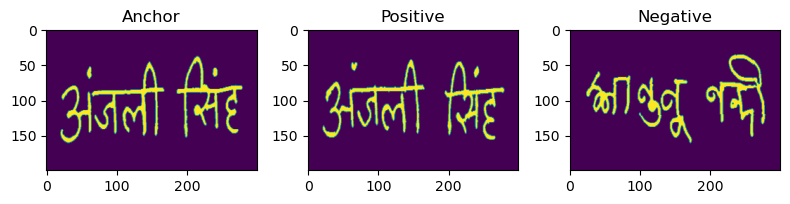

In [16]:
from torch.utils.data import DataLoader, SubsetRandomSampler
# Determine the number of samples to show
num_samples_to_show = 5

num_samples = len(loader.dataset)
random_indices = np.random.choice(num_samples, num_samples_to_show, replace=False)
sampler = SubsetRandomSampler(random_indices)
random_loader = DataLoader(dataset, batch_size=1, sampler=sampler)
show_triplets_from_dataloader(random_loader, num_samples_to_show) #nampilkasn 5 sample

In [17]:
len(loader)

938

Efficient

In [18]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute attention weights
        attention_scores = self.conv(x)
        attention_weights = self.sigmoid(attention_scores)

        # Apply attention to the input feature map
        attended_features = x * attention_weights

        return attended_features


class SiameseResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super(SiameseResNet, self).__init__()
        self.baseModel = models.resnet18(pretrained=pretrained)

        # Experiment with different spatial sizes based on the image resolution and signature complexity
        self.attention1 = SpatialAttention(in_channels=64)  # Spatial attention for layer 1
        self.attention2 = SpatialAttention(in_channels=128)  # Spatial attention for layer 2
        self.baseModel.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.baseModel.fc = nn.Identity()

    def forward(self, x):
        out = self.baseModel.conv1(x)
        out = self.baseModel.bn1(out)
        out = self.baseModel.relu(out)
        out = self.baseModel.maxpool(out)

        out = self.attention1(self.baseModel.layer1(out))  # Applying spatial attention to layer 1
        out = self.attention2(self.baseModel.layer2(out))  # Applying spatial attention to layer 2
        out = self.baseModel.layer3(out)  # No attention for layer 3
        out = self.baseModel.layer4(out)  # No attention for layer 4

        out = self.baseModel.avgpool(out)
        out = torch.flatten(out, 1)
        return out

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_anchor_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_anchor_negative = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.clamp(distance_anchor_positive - distance_anchor_negative + self.margin, min=0.0)
        return loss.mean()

In [20]:
def train_model(model, loader, n_epochs, optimizer, loss_fn):
    history = {'train_loss': []}
    print("------------------------Training--------------------------")
    for epoch in range(1, n_epochs + 1):
        t0 = datetime.now()
        print(f"Beginning Epoch {epoch}/{n_epochs}...")
        train_loss = []
        model.train()
        for i, data in tqdm(enumerate(loader, 0)):
            anchor, positive, negative = data
            anchor = anchor.to(device=device)
            positive = positive.to(device=device)
            negative = negative.to(device=device)
            
            optimizer.zero_grad()
            anchor_embeddings = model(anchor)  
            positive_embeddings = model(positive)  
            negative_embeddings = model(negative) 

            loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)  # Changed `triplet_loss` to `loss_fn`
            
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())  # Added the loss value to `train_loss` list
            dt = datetime.now() - t0
        print('\nEpoch: {}\tTrain Loss: {}\tDuration: {}'.format(epoch, np.mean(train_loss), dt))

        # Tracking accuracy and loss in each epoch for plot
        history['train_loss'].append(np.mean(train_loss))
    
    return history

In [21]:
margin = 0.1

# Create an instance of SiameseResnet with the ResNet model and embedding size
siamese_model = SiameseResNet()
siamese_model = nn.DataParallel(siamese_model).to(device)

triplet_loss = TripletLoss(margin).to(device)
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)

In [22]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [23]:
from torchsummary import summary

model = SiameseResNet()
model = nn.DataParallel(model).to(device)
summary(model, (1, 200, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 150]           3,136
       BatchNorm2d-2         [-1, 64, 100, 150]             128
              ReLU-3         [-1, 64, 100, 150]               0
         MaxPool2d-4           [-1, 64, 50, 75]               0
            Conv2d-5           [-1, 64, 50, 75]          36,864
       BatchNorm2d-6           [-1, 64, 50, 75]             128
              ReLU-7           [-1, 64, 50, 75]               0
            Conv2d-8           [-1, 64, 50, 75]          36,864
       BatchNorm2d-9           [-1, 64, 50, 75]             128
             ReLU-10           [-1, 64, 50, 75]               0
       BasicBlock-11           [-1, 64, 50, 75]               0
           Conv2d-12           [-1, 64, 50, 75]          36,864
      BatchNorm2d-13           [-1, 64, 50, 75]             128
             ReLU-14           [-1, 64,

In [24]:
print(siamese_model)

DataParallel(
  (module): SiameseResNet(
    (baseModel): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

In [27]:
num_epochs = 15

history = train_model(siamese_model, loader, num_epochs, optimizer, triplet_loss)



------------------------Training--------------------------
Beginning Epoch 1/15...


1it [00:12, 12.57s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, 16), history['train_loss'], 'b', label='Triplet Loss')
plt.title('Triplet Loss of Model', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

In [ ]:
torch.save(siamese_model.state_dict(),'resnet_with_attention_triplet_saturday.pth') 

In [ ]:
import torch.nn.functional as F

class LogisticSiameseRegression(nn.Module):
    def __init__(self, model):
        super(LogisticSiameseRegression, self).__init__()
        
        self.model = model
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward_once(self, x):
        out = self.model(x)
        out = F.normalize(out, p=2, dim=1)  # L2 normalization
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        diff = out1 - out2
        out = self.fc(diff)
        out = self.sigmoid(out)
        return out

In [ ]:
def train(model, input1, input2, outputs, optimizer, loss_fn):
    # Set the model to training mode
    model.train()
    # Zero the gradients
    optimizer.zero_grad()
    # Compute the model's predictions
    predictions = model(input1, input2)
    # Compute the loss
    loss = loss_fn(predictions, outputs)
    # Compute the gradients
    loss.backward()
    # Update the weights
    optimizer.step()
    return loss, predictions


def train_model(model, train_loader, test_loader, n_epochs, optimizer, loss_fn):
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
    print("------------------------Training--------------------------")

    for epoch in range(1, n_epochs + 1):
        t0 = datetime.now()
        print(f"Beginning Epoch {epoch}/{n_epochs}...")
        train_loss = []
        train_acc = []
        model.train()
        for i, data in tqdm(enumerate(train_loader, 0)):
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device=device)
            inputs2 = inputs2.to(device=device)
            targets = targets.to(device=device)

            loss, predictions = train(model, inputs1, inputs2, targets, optimizer, loss_fn)
            train_loss.append(loss.item())
            accuracy = (predictions.round() == targets).float().mean().item()
            train_acc.append(accuracy)

        valid_loss = []
        valid_acc = []
        model.eval()
        with torch.no_grad():
            for i, data in tqdm(enumerate(test_loader, 0)):
                inputs1, inputs2, targets = data
                inputs1 = inputs1.to(device=device)
                inputs2 = inputs2.to(device=device)
                targets = targets.to(device=device)

                output = model(inputs1, inputs2)
                loss = loss_fn(output, targets)
                valid_loss.append(loss.item())
                accuracy = (output.round() == targets).float().mean().item()
                valid_acc.append(accuracy)

        dt = datetime.now() - t0
        print('\nEpoch: {}\t\tTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\nDuration: {}\tValid Loss: {:.4f}\tValid Accuracy: {:.4f}\n'.format(
             epoch, np.mean(train_loss), np.mean(train_acc), dt, np.mean(valid_loss), np.mean(valid_acc)
        ))

        # Tracking accuracy and loss in each epoch for plot
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
        history['valid_loss'].append(np.mean(valid_loss))
        history['valid_acc'].append(np.mean(valid_acc))
    
    return history

In [ ]:
cedar_dataset = '/kaggle/input/signature-forgery-dataset/Train'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

# cedar_duplet = cedar_duplet.sample(10000, random_state=42)
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)
indices = list(range(len(cedar_dataset)))
split = int(np.floor(0.80 * len(cedar_dataset)))  # train_size
validation = int(np.floor(0.70 * split))   # validation
np.random.shuffle(indices)

train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=validation_sampler
)

In [ ]:
model_rms = LogisticSiameseRegression(siamese_model).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model_rms.parameters(), lr=0.001)

history = train_model(model_rms, train_loader, test_loader, 10, optimizer, loss_fn)


In [ ]:
torch.save(model_rms.state_dict(),'model_final_attention_saturday.pth')

In [ ]:
def plot_acc_loss(history, num_epochs):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    axes[0].plot(range(1, num_epochs+1), history['train_acc'], 'b', label='Training Accuracy')
    axes[0].plot(range(1, num_epochs+1), history['valid_acc'], 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy of Model', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].legend()
    
    axes[1].plot(range(1, num_epochs+1), history['train_loss'], 'b', label='Training Loss')
    axes[1].plot(range(1, num_epochs+1), history['valid_loss'], 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss of Model', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Loss', fontsize=14)
    axes[1].legend()
    
    plt.show()

plot_acc_loss(history, 10)

In [ ]:
def calculate_accuracy(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            outputs = model(inputs1, inputs2)
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
    
    accuracy = correct / total * 100
    return accuracy

def get_predictions(data_loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    for i, data in tqdm(enumerate(data_loader, 0)):
        inputs1, inputs2, targets = data
        inputs1 = inputs1.to(device=device)
        inputs2 = inputs2.to(device=device)
        targets = targets.to(device=device)

        output = model(inputs1, inputs2)
        predictions = (output > 0.5).float().tolist()  # Convert predictions to list format
        all_preds.extend(predictions)
        all_labels.extend(targets.tolist())
        
    return all_preds, all_labels


from sklearn.metrics import confusion_matrix
import seaborn as sns

def build_confusion_matrix(preds, labels):
    # Build confusion matrix
    cm = confusion_matrix(preds, labels)
    
    # Normalize the confusion matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Define the labels
    labels = ['Genuine', 'Forged']
    # Plot the confusion matrix
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
    plt.gca().set_xticklabels(labels, rotation=0)
    plt.gca().set_yticklabels(labels, rotation=0)
    # Set the axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentage)')

    # Display the plot
    plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds, lables = get_predictions(validation_loader, model_rms)
print(classification_report(preds, lables))
build_confusion_matrix(preds, lables)

In [ ]:
cedar_dataset = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

# cedar_duplet = cedar_duplet.sample(10000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

In [ ]:
cedar_dataset = '/kaggle/input/signature-forgery-dataset/Test'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)


# cedar_duplet = cedar_duplet.sample(10000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)


In [ ]:
cedar_dataset = '/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

cedar_duplet = cedar_duplet.sample(12000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)


In [ ]:
cedar_dataset = '/kaggle/input/handwritten-signature-datasets/BHSig260-Bengali/BHSig260-Bengali'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

cedar_duplet = cedar_duplet.sample(12000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

In [ ]:
def get_predictions_for_single(img1, img2, model):
    # Load the images
    image1 = Image.open(img1)
    plt.imshow(image1)
    plt.show()
    image1 = preprocess_image(image1)
    image2 = Image.open(img2)
    plt.imshow(image2)
    plt.show()
    image2 = preprocess_image(image2)
    
    
    
    # Preprocess the images
    transform = transforms.Compose([
        transforms.Resize((200,300)),
#         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ])
    input1 = transform(image1).unsqueeze(0).to(device)
    input2 = transform(image2).unsqueeze(0).to(device)
    
    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        predictions = model(input1, input2)
        print(predictions)

    # Determine the prediction label
    if predictions < 0.2:
        print("The signatures are similar.")
    else:
        print("The signatures are not similar.")


In [ ]:
img1 = "/kaggle/input/signature-forgery-dataset/Test/2/original_02_03.jpg"
img2 = "/kaggle/input/signature-forgery-dataset/Test/3/original_03_03.jpg"
get_predictions_for_single(img1, img2, model_rms)

In [ ]:
from scipy.ndimage import rotate
def test_preprocess_image(image_pth,delta=1, limit=10):
    
    def determine_score(arr, angle):
        data = rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score
    
    # Convert image to grayscale
    gray = image_pth.convert("L")

    # Convert grayscale image to numpy array
    img = np.array(gray)
    # Apply median blur
    blur = cv2.medianBlur(img,3)

    # Define kernel for morphology operations
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    # Perform erosion
    erode = cv2.erode(blur, kernel, iterations=2)

    # Perform dilation
    dilate = cv2.dilate(erode, kernel, iterations=1)
    # Apply thresholding
    _, binary = cv2.threshold(dilate, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find the bounding box coordinates of the non-white pixels
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    # Add extra white space to the bounding box coordinates
    padding = 20  # Adjust the padding size as needed
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    # Make sure the coordinates are within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the image using the modified bounding box coordinates
    cropped_image = binary[y:y+h, x:x+w]

    # Add extra white space around the cropped image
    extra_space = np.zeros((cropped_image.shape[0] + 2 * padding, cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(extra_space, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = extra_space.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(extra_space, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # Convert the numpy array back to PIL image
    resized_image = Image.fromarray(corrected)

    return resized_image

In [ ]:
import random

def test_dataset(dataset_folder):
    """
    This function returns a dataframe
    Dataframe consists of ClassName, Testing Image and Label
    """
    df = pd.DataFrame(columns=['ClassName', 'Image', 'Label'])

    for person_folder in os.listdir(dataset_folder):
        class_name = str(person_folder)
        person_folder_path = os.path.join(dataset_folder, person_folder)
        images = os.listdir(person_folder_path)
        selected_images = random.sample(images, k=min(5, len(images)))  # Randomly select up to five images

        for image in selected_images:
            image_path = os.path.join(person_folder_path, image)
            is_genuine = True if 'original' in image or '-G-' in image else False
            label = 0 if is_genuine else 1
            df = df.append({'ClassName': class_name, 'Image': image_path, 'Label': label}, ignore_index=True)

    return df

In [ ]:
def get_genuine_with_class(dataset_folder):
    """
    This function returns a dataframe consisting of 4 genuine images 
    for each class
    """
    # Create an empty DataFrame
    df = pd.DataFrame(columns=['GenuineImages', 'Class'])

    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)

        if not os.path.isdir(class_folder_path):
            continue  # Skip non-directory files

        genuine_images = []
        counter = 0  # Counter for tracking the number of genuine images added

        for filename in os.listdir(class_folder_path):
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(filename)
                counter += 1  # Increment the counter

                if counter == 5:
                    break  # Break out of the loop if 4 genuine images have been added
        # Add genuine image paths to DataFrame
        data = []
        for image in genuine_images:
            image_path = os.path.join(class_folder_path, image)
            data.append([image_path, class_folder])

        df = df.append(pd.DataFrame(data, columns=['GenuineImages', 'Class']), ignore_index=True)

    return df

In [ ]:
def get_genuine_and_test_images_for_class(df, class_id, test_image):
    class_images = df.loc[df['Class'] == class_id, 'GenuineImages']
    test_images = [test_image] * len(class_images)
    class_images = pd.DataFrame({'GenuineImages': class_images, 'TestImage': test_images})
    return class_images

In [ ]:
class GenuineTestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        genuine_image_path = row['GenuineImages']
        test_image_path = row['TestImage']

        genuine_image = Image.open(genuine_image_path)
        test_image = Image.open(test_image_path)
        
        genuine_image = test_preprocess_image(genuine_image)
        test_image = test_preprocess_image(test_image)
        
        if self.transform is not None:
            genuine_image = self.transform(genuine_image)
            test_image = self.transform(test_image)

        return genuine_image, test_image

In [ ]:
def perform_voting(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    positive_votes = 0
    negative_votes = 0
    
    # Iterate over the dataset
    for i, data in tqdm(enumerate(dataloader, 0)):
        genuine_image, test_image = data
        genuine_image = genuine_image.to(device)
        test_image = test_image.to(device)
        
        with torch.no_grad():
            output = model(genuine_image, test_image)
            if output < 0.4:
                positive_votes += 1
            else:
                negative_votes += 1
    # Determine the final prediction based on voting
    if positive_votes > negative_votes:
        final_prediction = 0   # Genuine
    else:
        final_prediction = 1   # Forged
    
    return final_prediction

In [ ]:
def peform_voting_for_each_test_images(folder):
#     folder = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR'
    test_df = get_genuine_with_class(folder)
    
    test_images = test_dataset(folder)
    all_preds = []
    all_labels = []
    
    for index, row in test_images.iterrows():
        class_name = row['ClassName']
        image_path = row['Image']
        label = row['Label']
        desired_df = get_genuine_and_test_images_for_class(test_df,class_name, image_path)
    
        # Create an instance of the GenuineTestDataset
        dataset = GenuineTestDataset(desired_df, transform=transformation)

        # Create a DataLoader for batching and loading the data
        dataloader = DataLoader(dataset, batch_size=1)
        predictions = perform_voting(model_rms, dataloader)
        all_preds.append(predictions)
        all_labels.append(label)
        print(f"{class_name}\t{image_path}\t{label}\t{predictions}")
        
    return all_preds, all_labels

In [ ]:
folder = '/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR'
preds,labels = peform_voting_for_each_test_images(folder)

In [ ]:
build_confusion_matrix(preds,labels)
print(classification_report(preds,labels))
confusion_matrix(preds,labels)


In [ ]:
## On Train
folder = '/kaggle/input/signature-forgery-dataset/Train'
preds,labels = peform_voting_for_each_test_images(folder)


In [ ]:
build_confusion_matrix(preds,labels)
print(classification_report(preds, labels))

In [ ]:
def perform_voting(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    positive_votes = 0
    negative_votes = 0
    
    # Iterate over the dataset
    for i, data in tqdm(enumerate(dataloader, 0)):
        genuine_image, test_image = data        
        genuine_image = genuine_image.to(device)
        test_image = test_image.to(device)
        
        with torch.no_grad():
            output = model(genuine_image, test_image)
            print(output)
            if output < 0.4:
                positive_votes += 1
            else:
                negative_votes += 1
    
    print(f"Positive Votes: {positive_votes} \t Negative votes: {negative_votes}")
    # Determine the final prediction based on voting
    if positive_votes > negative_votes:
        final_prediction = "Genuine"
    else:
        final_prediction = "Forged"
    
    return final_prediction

In [ ]:
folder = '/kaggle/input/signature-forgery-dataset/Test'
test_df = get_genuine_with_class(folder)
test_image = '/kaggle/input/signature-forgery-dataset/Test/3/forge_03_02.jpg'
desired_df = get_genuine_and_test_images_for_class(test_df, "23",test_image)
# Create an instance of the GenuineTestDataset
dataset = GenuineTestDataset(desired_df, transform=transformation)

# Create a DataLoader for batching and loading the data
dataloader = DataLoader(dataset, batch_size=1)


len(dataloader)
perform_voting(model_rms, dataloader)